In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
# import requests
# from io import StringIO
import numpy as np
from datetime import datetime

### load in the data

In [2]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')
holdout_mini = pd.read_csv(
    'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')


def get_data_from_url(url):
    # response = requests.get(url)
    #
    # # Check if the request was successful
    # if response.status_code == 200:
    #     data = StringIO(response.text)
    #     df = pd.read_csv(data)
    #     # Now you can work with the dataframe
    #     return df
    # else:
    #     print("Error: Unable to retrieve data from the URL.")
    #     return None
    return pd.read_csv(url)


global irs_2014
global irs_2015

irs_2014 = get_data_from_url('https://www.irs.gov/pub/irs-soi/14zpallnoagi.csv')
irs_2015 = get_data_from_url('https://www.irs.gov/pub/irs-soi/15zpallnoagi.csv')

irs_2014['zipcode'] = irs_2014['ZIPCODE']
irs_2015['zipcode'] = irs_2015['ZIPCODE']

# Preprocessing function

In [3]:
def preprocess_and_create_options(df: pd.DataFrame):
    """
    process data and return the following df's 
    normal_df - just fixed bad columns in original data
    added_columns_df - added features based on original columns 
    normalized_df - normalized added_columns_df
    irs_df - augment features based off of IRS data also includes added_columns_df
    normalized_irs_df - normalized irs_df
    """
    # fix bad columns
    df['date'] = [x.split('T')[0] for x in df['date']]

    normal_df = df.copy(deep=True)

    # add new columns
    df['opinion_score'] = df['view'] + df['condition'] + df['grade']
    df['year_of_data'] = [int(x[0:4]) for x in df['date']]
    df['month_of_data'] = [int(x[4:6]) for x in df['date']]
    df['years_since_renovation'] = df['year_of_data'] - (
        df['yr_renovated'].where(df['yr_renovated'] != 0, df['yr_built']))

    def calculate_distance(lat2, lon2):
        """
        returns the distance of a latitude longitude pair to seattle, washington in kilometers
        """
        # Coordinates of Seattle
        lat1 = 47.6062  # Latitude of Seattle
        lon1 = -122.3321  # Longitude of Seattle

        # Convert latitude and longitude from degrees to radians
        lat1 = math.radians(lat1)
        lon1 = math.radians(lon1)
        lat2 = math.radians(lat2)
        lon2 = math.radians(lon2)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        radius_of_earth = 6371  # Radius of the Earth in kilometers
        distance = radius_of_earth * c

        return distance

    def convert_to_unix_time(date_string):
        date_object = datetime.strptime(date_string, date_format)
        unix_time = int(date_object.timestamp())
        return unix_time

    date_format = "%Y%m%d"
    df['unix_time'] = df['date'].apply(convert_to_unix_time)

    df['kms_to_seattle'] = df.apply(lambda row: calculate_distance(row['lat'], row['long']), axis=1)

    added_columns_df = df.copy(deep=True)

    normalized_df = pd.DataFrame()
    to_normalize = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                    'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                    'sqft_basement',
                    'sqft_living15', 'sqft_lot15', 'opinion_score', 'year_of_data',
                    'month_of_data', 'years_since_renovation',
                    'kms_to_seattle']

    scaler = MinMaxScaler()

    for x in df.columns:
        if x in to_normalize:
            normalized_df[x] = scaler.fit_transform(df[[x]])
        else:
            normalized_df[x] = df[x]

    # List of attributes to merge 
    # All of these are averages for a zipcode at the year of the sale
    # num in the name refers to number of returns with the given quality
    # other columns are average for that zipcode of the certain thing
    attributes = {
        'A00100': 'gross_income',
        'N00700': 'num_state_refunds',
        'N00900': 'num_business_income',
        'SCHF': 'num_farm_returns',
        'N03300': 'num_slf_emply_rtire_pln',
        'A18425': 'state_local_income_tax',
        'A18450': 'state_local_gen_sales_tax',
        'N18500': 'num_real_estate_taxes',
        'A18500': 'real_estate_tax_amt',
        'A19300': 'mortgage_interest_paid_amt',
        'N07260': 'num_res_energy_tax_cred',
        'TCE': 'num_tax_counsel_for_elderly'
    }

    # Merge the attributes from irs_2014 and irs_2015 into the df dataframe
    for attr, name in attributes.items():
        merged_attr = df.merge(irs_2014[['zipcode', attr]], on='zipcode', how='left')
        merged_attr = merged_attr.merge(irs_2015[['zipcode', attr]], on='zipcode', how='left')
        df[name] = np.where(df['year_of_data'] == 2014, merged_attr[attr + '_x'], merged_attr[attr + '_y'])

    irs_df = df.copy(deep=True)

    normalized_irs_df = pd.DataFrame()
    to_normalize = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                    'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                    'sqft_basement',
                    'sqft_living15', 'sqft_lot15', 'opinion_score', 'year_of_data',
                    'month_of_data', 'years_since_renovation',
                    'kms_to_seattle', 'gross_income',
                    'num_state_refunds', 'num_business_income', 'num_farm_returns',
                    'num_slf_emply_rtire_pln', 'state_local_income_tax',
                    'state_local_gen_sales_tax', 'num_real_estate_taxes',
                    'real_estate_tax_amt', 'mortgage_interest_paid_amt',
                    'num_res_energy_tax_cred', 'num_tax_counsel_for_elderly']

    scaler = MinMaxScaler()

    for x in df.columns:
        if x in to_normalize:
            normalized_irs_df[x] = scaler.fit_transform(df[[x]])
        else:
            normalized_irs_df[x] = df[x]

    return normal_df, added_columns_df, normalized_df, irs_df, normalized_irs_df

### Load all possible DF's 

In [4]:
normal_housing, added_columns_housing, normalized_housing, irs_housing, normalized_irs_housing = preprocess_and_create_options(
    housing)
normal_holdout, added_columns_holdout, normalized_holdout, irs_holdout, normalized_irs_holdout = preprocess_and_create_options(
    holdout)
normal_holdout_mini, added_columns_holdout_mini, normalized_holdout_mini, irs_holdout_mini, normalized_irs_holdout_mini = preprocess_and_create_options(
    holdout_mini)

# Brian's Stuff

# Use Grid/Random Search to Train and Select Best Models

This will be performed for each of the possible dataframes to determine which sets of augmented features are most helpful.

In [5]:
dataframes = {
    "normal housing": normal_housing,
    "added columns housing": added_columns_housing,
    "normalized housing": normalized_housing,
    "irs housing": irs_housing,
    "normalized irs housing": normalized_irs_housing
}


Training based on the 'added columns housing' dataset
0.8157348944301145
evaluating added columns housing: 
	R2: 0.8137440578254069
	RMSE: 159674.4512490819


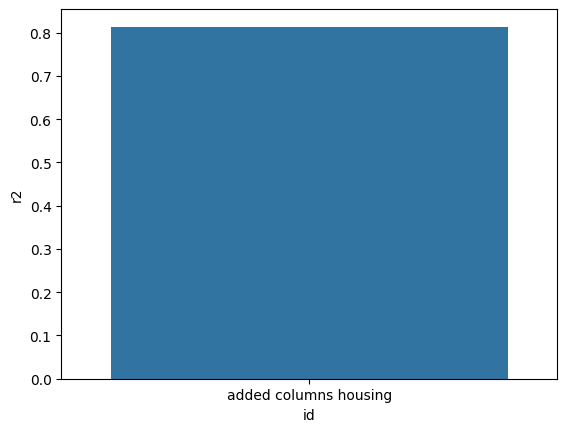

In [6]:
from evaluation import EvaluationSet, SplitType
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

columns_to_drop = ['price', 'date', 'id']

# Custom object Joel created for accumulating different results
evaluation_set = EvaluationSet()

for name, dataframe in dataframes.items():
    print(f"Training based on the '{name}' dataset")

    # Define X/y
    y = dataframe.price
    X = dataframe.drop(columns_to_drop, axis=1)

    # Split into Train/Eval/Test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8) # Only for quicker training
    # X_train, y_train, X_validate, y_validate = train_test_split(X_train, y_train, test_size=0.2)
    # X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2)


    # Perform the Grid/Random Search
    random_search = RandomizedSearchCV(XGBRegressor(), param_grid, cv=5)
    random_search.fit(X_train, y_train)

    # Get the best model & its metrics
    best_model: XGBRegressor = random_search.best_estimator_
    print(random_search.best_score_)

    # Generate predictions for the test (or evaluate?) dataset
    y_pred = best_model.predict(X_test)

    evaluation_set.evaluate(name, SplitType.TEST, y_test, y_pred)

evaluation_set.report()

